# 01 Data Exploration & Quality Check
### BDBA Capstone: Demographic Flows and Passive Equity Markets
**Author:** Antonio de Ipina  
**Date:** February 2026

This notebook loads, inspects, and validates all raw data inputs before they enter the simulation model. Each section maps to one of the five model modules.

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Path to data folder
DATA_PATH = '..\data'

# Display settings
pd.set_option('display.max_columns', 15)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')

print("Setup complete.")

Setup complete.


## 1. Module 1: Demographics (Census Population Projections)
Source: U.S. Census Bureau, 2023 National Population Projections (NP2023_D1)  
Three scenarios: **mid** (main projection), **hi** (high immigration), **low** (low immigration)

Columns: SEX, ORIGIN, RACE, YEAR, TOTAL_POP, POP_0 through POP_100  
We filter to SEX=0 (both), ORIGIN=0 (total), RACE=0 (all races) to get total U.S. population by single year of age.

### 1.1 Load and inspect raw data

In [2]:
# Load all three scenarios
census_mid = pd.read_csv(f'{DATA_PATH}/module1_demographics/np2023_d1_mid.csv')
census_hi = pd.read_csv(f'{DATA_PATH}/module1_demographics/np2023_d1_hi.csv')
census_low = pd.read_csv(f'{DATA_PATH}/module1_demographics/np2023_d1_low.csv')

print(f"Mid shape: {census_mid.shape}")
print(f"Hi shape:  {census_hi.shape}")
print(f"Low shape: {census_low.shape}")
print(f"\nColumns (first 10): {list(census_mid.columns[:10])}")
print(f"Columns (last 5):  {list(census_mid.columns[-5:])}")
census_mid.head(3)

Mid shape: (4332, 106)
Hi shape:  (4332, 106)
Low shape: (4332, 106)

Columns (first 10): ['SEX', 'ORIGIN', 'RACE', 'YEAR', 'TOTAL_POP', 'POP_0', 'POP_1', 'POP_2', 'POP_3', 'POP_4']
Columns (last 5):  ['POP_96', 'POP_97', 'POP_98', 'POP_99', 'POP_100']


,SEX,ORIGIN,RACE,YEAR,TOTAL_POP,POP_0,POP_1,...,POP_94,POP_95,POP_96,POP_97,POP_98,POP_99,POP_100
0,0,0,0,2022,333287557,3683113,3588817,...,248895,194667,145421,109622,78028,53870,88988
1,0,0,0,2023,334906305,3631327,3695123,...,253443,203141,155804,113960,83998,58334,96220
2,0,0,0,2024,336482168,3636897,3646544,...,267171,207018,162723,122212,87417,62906,101480


### 1.2 Filter to total population (both sexes, all races, all origins)

In [3]:
def filter_total_population(df, label):
    """Filter Census data to total population rows only."""
    filtered = df[(df['SEX'] == 0) & (df['ORIGIN'] == 0) & (df['RACE'] == 0)].copy()
    filtered = filtered.sort_values('YEAR').reset_index(drop=True)
    print(f"{label}: {len(filtered)} years, {filtered['YEAR'].min()} to {filtered['YEAR'].max()}")
    return filtered

mid = filter_total_population(census_mid, "Mid")
hi = filter_total_population(census_hi, "Hi")
low = filter_total_population(census_low, "Low")

Mid: 79 years, 2022 to 2100
Hi: 79 years, 2022 to 2100
Low: 79 years, 2022 to 2100


### 1.3 Sanity check total population over time
Verify that 2022 base year is ~330M and projections reach ~370-400M by 2060.

In [4]:
# Check 1: Does sum of age columns match TOTAL_POP?
age_cols = [f'POP_{i}' for i in range(101)]
mid['AGE_SUM'] = mid[age_cols].sum(axis=1)
mid['DIFF'] = mid['TOTAL_POP'] - mid['AGE_SUM']
print("Max discrepancy between TOTAL_POP and sum of age columns:", mid['DIFF'].abs().max())

# Check 2: Base year population (2022) should be ~330M+
base_pop = mid.loc[mid['YEAR'] == 2022, 'TOTAL_POP'].values[0]
print(f"\n2022 base population: {base_pop:,.0f}")

# Check 3: Scenario spread at key years
for year in [2025, 2035, 2045, 2050]:
    m = mid.loc[mid['YEAR'] == year, 'TOTAL_POP'].values[0] / 1e6
    h = hi.loc[hi['YEAR'] == year, 'TOTAL_POP'].values[0] / 1e6
    l = low.loc[low['YEAR'] == year, 'TOTAL_POP'].values[0] / 1e6
    print(f"{year}: Low {l:.1f}M | Mid {m:.1f}M | High {h:.1f}M | Spread: {h-l:.1f}M")

Max discrepancy between TOTAL_POP and sum of age columns: 0

2022 base population: 333,287,557
2025: Low 336.5M | Mid 338.0M | High 340.3M | Spread: 3.8M
2035: Low 344.0M | Mid 350.9M | High 361.2M | Spread: 17.2M
2045: Low 345.8M | Mid 358.4M | High 377.4M | Spread: 31.6M
2050: Low 345.0M | Mid 360.6M | High 384.1M | Spread: 39.0M


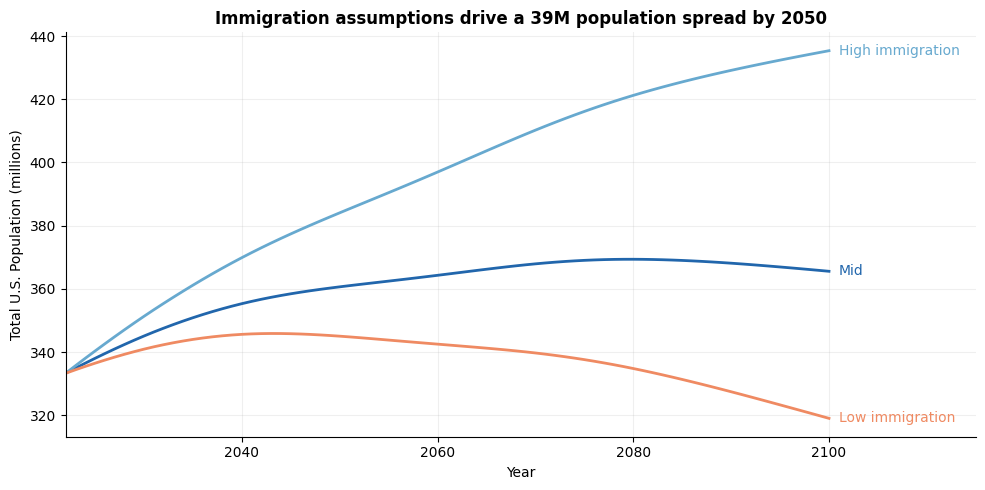

In [5]:
fig, ax = plt.subplots(figsize=(10, 5))

for df, label, color in [(mid, 'Mid', '#2166ac'), (hi, 'High immigration', '#67a9cf'), (low, 'Low immigration', '#ef8a62')]:
    ax.plot(df['YEAR'], df['TOTAL_POP'] / 1e6, color=color, linewidth=2)
    # Direct label at end of each line
    ax.text(df['YEAR'].iloc[-1] + 1, df[df['YEAR'] == 2100]['TOTAL_POP'].values[0] / 1e6,
            label, color=color, fontsize=10, va='center')

ax.set_xlabel('Year')
ax.set_ylabel('Total U.S. Population (millions)')
ax.set_title('Immigration assumptions drive a 39M population spread by 2050', fontsize=12, fontweight='bold')
ax.grid(True, alpha=0.2)
ax.set_xlim(2022, 2115)  # Extra space for labels
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### 1.4 Extract age cohort arrays for model period (2025–2050)
Build a matrix: rows = years, columns = single-year ages (0–100).  
This is the core demographic input for Modules 2 and 3.

In [6]:
# Age columns are POP_0 through POP_100
age_cols = [f'POP_{i}' for i in range(101)]

# Filter to model period
model_years = range(2025, 2051)

def extract_age_matrix(df, years):
    """Extract population-by-age matrix for specified years."""
    subset = df[df['YEAR'].isin(years)].set_index('YEAR')[age_cols]
    subset.columns = range(101)  # rename columns to integer ages
    return subset

pop_mid = extract_age_matrix(mid, model_years)
pop_hi = extract_age_matrix(hi, model_years)
pop_low = extract_age_matrix(low, model_years)

print(f"Age matrix shape: {pop_mid.shape}")
print(f"Years: {pop_mid.index.min()} to {pop_mid.index.max()}")
print(f"Ages: {pop_mid.columns.min()} to {pop_mid.columns.max()}")
pop_mid.head(3)

Age matrix shape: (26, 101)
Years: 2025 to 2050
Ages: 0 to 100


,0,1,2,3,4,5,6,...,94,95,96,97,98,99,100
YEAR,,,,,,,,,,,,,,,
2025,3641659,3652257,3661925,3720050,3627091,3730971,3779855,...,272160,218386,165976,127760,93846,65550,106523
2026,3646146,3657183,3667779,3676277,3731905,3639101,3742897,...,276566,222680,175226,130440,98205,70453,110819
2027,3650366,3661834,3672842,3682260,3689938,3743653,3650937,...,280589,226476,178861,137828,100371,73804,116676


### 1.5 Visualize key age groups relevant to the model
- **Working age (22–64):** Main contributors to 401(k) inflows (Module 2)
- **RMD age (73+/75+):** Mandatory withdrawal population (Module 3)
- **Peak cohort (1970–1973 births):** Hits RMD age 75 around 2045–2048

In [7]:
# ── Derived life-stage series (used throughout notebook) ────────
# These aggregate the age matrix into policy-relevant groups

pre_working = pop_mid.loc[:, 0:21].sum(axis=1)
working_age = pop_mid.loc[:, 22:64].sum(axis=1)
retired_pre = pop_mid.loc[:, 65:72].sum(axis=1)
rmd_age_73  = pop_mid.loc[:, 73:100].sum(axis=1)
rmd_age_75  = pop_mid.loc[:, 75:100].sum(axis=1)

print("Life-stage series created (2025–2050, mid scenario)")
print(f"  Working age (22–64):  {working_age.loc[2025]/1e6:.1f}M → {working_age.loc[2050]/1e6:.1f}M")
print(f"  RMD age (73+):        {rmd_age_73.loc[2025]/1e6:.1f}M → {rmd_age_73.loc[2050]/1e6:.1f}M")
print(f"  RMD age (75+):        {rmd_age_75.loc[2025]/1e6:.1f}M → {rmd_age_75.loc[2050]/1e6:.1f}M")

Life-stage series created (2025–2050, mid scenario)
  Working age (22–64):  186.2M → 196.1M
  RMD age (73+):        33.5M → 51.6M
  RMD age (75+):        27.4M → 45.1M


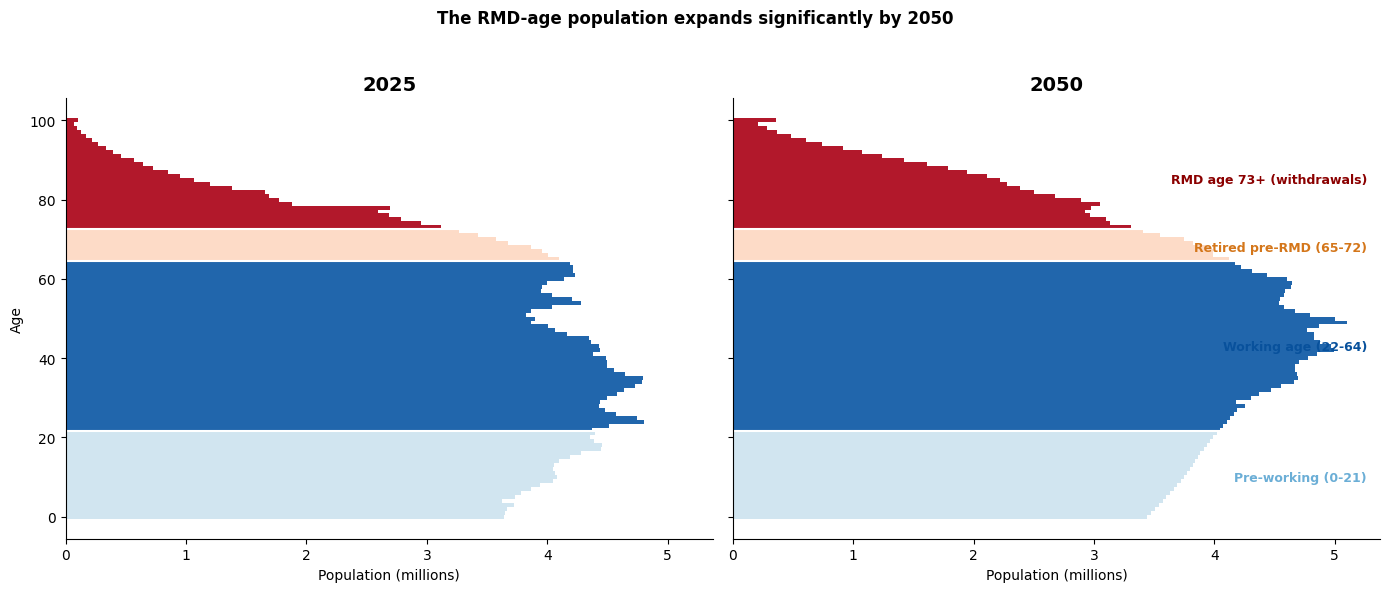

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

max_pop = pop_mid.max().max() / 1e6 * 1.05

for ax, year in [(axes[0], 2025), (axes[1], 2050)]:
    pop_data = pop_mid.loc[year] / 1e6

    colors = []
    for age in range(101):
        if age < 22:
            colors.append('#d1e5f0')
        elif age <= 64:
            colors.append('#2166ac')
        elif age <= 72:
            colors.append('#fddbc7')
        else:
            colors.append('#b2182b')

    ax.barh(range(101), pop_data, color=colors, height=1.0, edgecolor='none')
    ax.set_title(f'{year}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Population (millions)')
    ax.set_xlim(0, max_pop)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

axes[0].set_ylabel('Age')

# Labels only once, on the far right panel's y-axis side
# Use age midpoints and place text to the right of axes[1]
labels = [
    (10, 'Pre-working (0-21)', '#6baed6'),
    (43, 'Working age (22-64)', '#08519c'),
    (68, 'Retired pre-RMD (65-72)', '#d4761a'),
    (85, 'RMD age 73+ (withdrawals)', '#8b0000')
]

for y_pos, text, color in labels:
    axes[1].annotate(text,
                     xy=(max_pop * 0.98, y_pos),
                     fontsize=9, color=color, fontweight='bold',
                     va='center', ha='right')

# Horizontal dividers instead of dashed lines — subtler
for ax in axes:
    for age in [22, 65, 73]:
        ax.axhline(y=age - 0.5, color='white', linewidth=1.5)

fig.suptitle('The RMD-age population expands significantly by 2050',
             fontsize=12, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [9]:
# ── Summary table using pre-built series ────────────────────────
stages = {
    'Pre-working (0-21)':      pre_working,
    'Working age (22-64)':     working_age,
    'Retired pre-RMD (65-72)': retired_pre,
    'RMD age (73+)':           rmd_age_73,
}

print(f"{'Life Stage':<30}{'2025 (M)':>10}{'2050 (M)':>10}{'Change':>10}")
print("-" * 62)
for label, series in stages.items():
    v25 = series.loc[2025] / 1e6
    v50 = series.loc[2050] / 1e6
    pct = (v50 / v25 - 1) * 100
    print(f"{label:<30}{v25:>10.1f}{v50:>10.1f}{pct:>+9.1f}%")

total_25 = pop_mid.loc[2025].sum() / 1e6
total_50 = pop_mid.loc[2050].sum() / 1e6
print("-" * 62)
print(f"{'Total':<30}{total_25:>10.1f}{total_50:>10.1f}{(total_50/total_25-1)*100:>+9.1f}%")

Life Stage                      2025 (M)  2050 (M)    Change
--------------------------------------------------------------
Pre-working (0-21)                  88.5      82.4     -6.9%
Working age (22-64)                186.2     196.1     +5.3%
Retired pre-RMD (65-72)             29.9      30.6     +2.3%
RMD age (73+)                       33.5      51.6    +54.2%
--------------------------------------------------------------
Total                              338.0     360.6     +6.7%


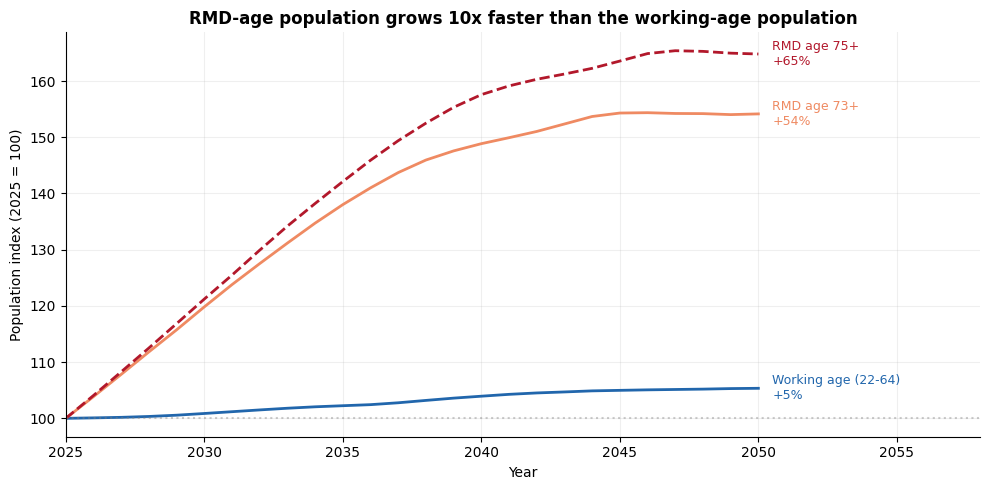

In [10]:
fig, ax = plt.subplots(figsize=(10, 5))

working_age_idx = working_age / working_age.loc[2025] * 100
rmd_73_idx = rmd_age_73 / rmd_age_73.loc[2025] * 100
rmd_75_idx = rmd_age_75 / rmd_age_75.loc[2025] * 100

ax.plot(pop_mid.index, working_age_idx, color='#2166ac', linewidth=2)
ax.plot(pop_mid.index, rmd_73_idx, color='#ef8a62', linewidth=2)
ax.plot(pop_mid.index, rmd_75_idx, color='#b2182b', linewidth=2, linestyle='--')
ax.axhline(y=100, color='gray', linestyle=':', alpha=0.4)

# Direct labels at end of each line
ax.text(2050.5, working_age_idx.loc[2050], f'Working age (22-64)\n+{working_age_idx.loc[2050]-100:.0f}%',
        color='#2166ac', fontsize=9, va='center')
ax.text(2050.5, rmd_73_idx.loc[2050], f'RMD age 73+\n+{rmd_73_idx.loc[2050]-100:.0f}%',
        color='#ef8a62', fontsize=9, va='center')
ax.text(2050.5, rmd_75_idx.loc[2050], f'RMD age 75+\n+{rmd_75_idx.loc[2050]-100:.0f}%',
        color='#b2182b', fontsize=9, va='center')

ax.set_xlabel('Year')
ax.set_ylabel('Population index (2025 = 100)')
ax.set_title('RMD-age population grows 10x faster than the working-age population', fontsize=12, fontweight='bold')
ax.set_xlim(2025, 2058)  # Extra space for labels
ax.grid(True, alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

### 1.7 Ratio check: RMD-age population as share of working-age population
This ratio captures the demographic pressure building in the system as it rises, outflows grow relative to inflows (According to the Hypothesis).

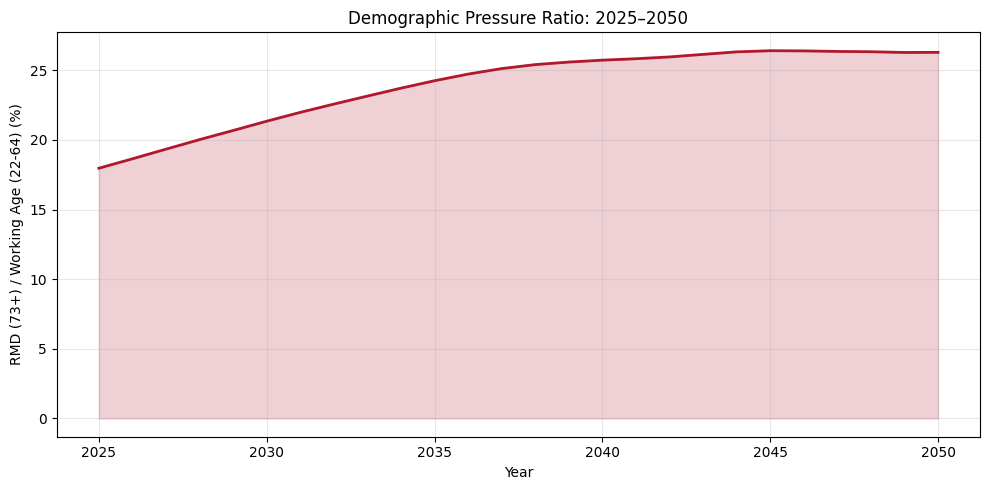

2025: 18.0%
2035: 24.3%
2045: 26.4%
2050: 26.3%


In [11]:
ratio = rmd_age_73 / working_age * 100

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(pop_mid.index, ratio, color='#b2182b', linewidth=2)
ax.fill_between(pop_mid.index, ratio, alpha=0.2, color='#b2182b')
ax.set_xlabel('Year')
ax.set_ylabel('RMD (73+) / Working Age (22-64) (%)')
ax.set_title('Demographic Pressure Ratio: 2025–2050')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"2025: {ratio.loc[2025]:.1f}%")
print(f"2035: {ratio.loc[2035]:.1f}%")
print(f"2045: {ratio.loc[2045]:.1f}%")
print(f"2050: {ratio.loc[2050]:.1f}%")

### 1.8 Save processed demographic data for Module 2 & 3
Export the cleaned age matrices so the model notebook can load them directly without re-filtering.

In [12]:
# Save processed age matrices
output_path = '../data/processed'
os.makedirs(output_path, exist_ok=True)

pop_mid.to_csv(f'{output_path}/pop_age_matrix_mid.csv')
pop_hi.to_csv(f'{output_path}/pop_age_matrix_hi.csv')
pop_low.to_csv(f'{output_path}/pop_age_matrix_low.csv')

print(f"Saved 3 age matrices to {output_path}/")
print(f"Each matrix: {pop_mid.shape[0]} years × {pop_mid.shape[1]} ages")

Saved 3 age matrices to ../data/processed/
Each matrix: 26 years × 101 ages


## 2. Module 2: Inflows (401(k) Contributions into US Equities)
Sources: BLS Usual Weekly Earnings Q3 2025, Vanguard How America Saves 2025, Vanguard TDF Glide Paths.  
This section explores the inflow pipeline: **Salary → Participation → Contribution → Equity Allocation** by age.

In [13]:
# ── 2.0 Load Module 2 data ──────────────────────────────────────────────────

# Module 1 output: population by single-year age
pop_mid = pd.read_csv(f'{DATA_PATH}/processed/pop_age_matrix_mid.csv', index_col='YEAR')
pop_mid.columns = pop_mid.columns.astype(int)

# Module 2 inputs
bls = pd.read_excel(f'{DATA_PATH}/module2_inflows/bls_earnings_by_age_q3_2025.xlsx',
                     header=2)
tdf = pd.read_excel(f'{DATA_PATH}/module2_inflows/TDF_glide_paths.xlsx',
                     header=2)
vanguard = pd.read_excel(f'{DATA_PATH}/module2_inflows/vanguard_data_extraction.xlsx',
                          sheet_name='ByAge_Module2', header=2)

# Clean column names: replace newlines from Excel wrap formatting
bls.columns = bls.columns.str.replace('\n', ' ')
tdf.columns = tdf.columns.str.replace('\n', ' ')
vanguard.columns = vanguard.columns.str.replace('\n', ' ')

print("Population matrix:", pop_mid.shape, f"({pop_mid.index.min()}–{pop_mid.index.max()}, ages 0–100)")
print(f"\nBLS columns: {list(bls.columns)}")
print(f"\nVanguard columns: {list(vanguard.columns)}")
print(f"\nTDF columns: {list(tdf.columns)}")

Population matrix: (26, 101) (2025–2050, ages 0–100)

BLS columns: ['Age Group', 'Workers (000s)', 'Median Weekly ($)', 'Annual (×52) ($)', 'Men Weekly ($)', 'Women Weekly ($)', 'Men Workers (000s)', 'Women Workers (000s)']

Vanguard columns: ['Age Group', 'Participation (All)', 'Participation (Auto-Enroll)', 'Participation (Voluntary)', 'Avg Deferral Rate', 'Avg Total Contrib Rate', 'Total Contrib (Auto-Enroll)', 'Total Contrib (Voluntary)', 'Avg Balance ($)', 'Median Balance ($)', 'Avg Equity Allocation', 'Median Equity Allocation', 'TDF Share of Assets']

TDF columns: ['Asset Class', '2070', '2065', '2060', '2055', '2050', '2045', '2040', '2035', '2030', '2025', '2020', 'Income']


In [17]:
# ── 2.1 Build unified parameter table by age group ──────────────────────────
# BLS age buckets (16-19, 20-24) → merge into <25 to align with Vanguard
# Weighted average by number of workers for the merge

bls_young = bls[bls['Age Group'].isin(['16-19', '20-24'])].copy()
workers_16 = bls_young.loc[bls_young['Age Group'] == '16-19', 'Workers (000s)'].values[0]
workers_20 = bls_young.loc[bls_young['Age Group'] == '20-24', 'Workers (000s)'].values[0]
wage_16 = bls_young.loc[bls_young['Age Group'] == '16-19', 'Median Weekly ($)'].values[0]
wage_20 = bls_young.loc[bls_young['Age Group'] == '20-24', 'Median Weekly ($)'].values[0]

wage_under25 = (wage_16 * workers_16 + wage_20 * workers_20) / (workers_16 + workers_20)
workers_under25 = workers_16 + workers_20

print(f"Merging BLS <25 bucket: 16-19 (${wage_16}/wk, {workers_16:,.0f}K) + 20-24 (${wage_20}/wk, {workers_20:,.0f}K)")
print(f"  → Weighted average: ${wage_under25:.0f}/wk, {workers_under25:,.0f}K total workers")
print(f"  → 20-24 dominates ({workers_20/(workers_16+workers_20)*100:.0f}% of weight)\n")

# Build aligned table: one row per Vanguard age group
age_groups = ['<25', '25-34', '35-44', '45-54', '55-64', '65+']

# Clean Vanguard: drop source note rows that loaded below the data
vanguard = vanguard.dropna(subset=['Participation (All)']).head(6)
print(f"Vanguard cleaned: {len(vanguard)} rows")

# Also clean BLS: drop total row and any NaN
bls = bls.dropna(subset=['Median Weekly ($)'])
bls = bls[bls['Age Group'] != 'Total 16+']

# BLS wages (weekly → annual)
bls_annual = {
    '<25':   wage_under25 * 52,
    '25-34': bls.loc[bls['Age Group'] == '25-34', 'Median Weekly ($)'].values[0] * 52,
    '35-44': bls.loc[bls['Age Group'] == '35-44', 'Median Weekly ($)'].values[0] * 52,
    '45-54': bls.loc[bls['Age Group'] == '45-54', 'Median Weekly ($)'].values[0] * 52,
    '55-64': bls.loc[bls['Age Group'] == '55-64', 'Median Weekly ($)'].values[0] * 52,
    '65+':   bls.loc[bls['Age Group'] == '65+',   'Median Weekly ($)'].values[0] * 52,
}

# TDF US equity share by age: map age group → approximate vintage year
# Logic: someone aged 30 in 2025 retires ~2060 → use 2060 fund
tdf_us_equity = tdf[tdf['Asset Class'] == 'US Stock'].iloc[0]
tdf_mapping = {
    '<25':   tdf_us_equity['2070'],    # Age ~20, retires ~2070
    '25-34': tdf_us_equity['2060'],    # Age ~30, retires ~2060
    '35-44': tdf_us_equity['2050'],    # Age ~40, retires ~2050
    '45-54': tdf_us_equity['2040'],    # Age ~50, retires ~2040
    '55-64': tdf_us_equity['2030'],    # Age ~60, retires ~2030
    '65+':   tdf_us_equity['Income'],  # Already retired
}

# Assemble the unified table
params = pd.DataFrame({
    'Age Group': age_groups,
    'Median Annual Salary ($)': [bls_annual[a] for a in age_groups],
    'Participation Rate': vanguard['Participation (All)'].values,
    'Total Contribution Rate': vanguard['Avg Total Contrib Rate'].values,
    'Avg Equity Allocation (Actual)': vanguard['Avg Equity Allocation'].values,
    'TDF US Equity Share (Model)': [tdf_mapping[a] for a in age_groups],
})

# Derived: effective US equity contribution per worker
params['Effective US Equity Rate'] = (
    params['Participation Rate']
    * params['Total Contribution Rate']
    * params['TDF US Equity Share (Model)']
)
params['Annual US Equity per Worker ($)'] = (
    params['Median Annual Salary ($)']
    * params['Effective US Equity Rate']
)

print("\nUNIFIED INFLOW PARAMETER TABLE — Module 2")
print("=" * 95)
header1 = f"{'Age':<8} {'Salary':>10} {'Partic':>8} {'Contrib':>9} {'Actual Eq':>10} {'TDF US Eq':>10} {'Eff Rate':>9} {'$/Worker':>10}"
header2 = f"{'Group':<8} {'(annual)':>10} {'Rate':>8} {'Rate':>9} {'Alloc':>10} {'(Model)':>10} {'':>9} {'(annual)':>10}"
print(header1)
print(header2)
print("-" * 95)
for _, r in params.iterrows():
    sal = r['Median Annual Salary ($)']
    par = r['Participation Rate']
    con = r['Total Contribution Rate']
    act = r['Avg Equity Allocation (Actual)']
    tdf_eq = r['TDF US Equity Share (Model)']
    eff = r['Effective US Equity Rate']
    ann = r['Annual US Equity per Worker ($)']
    print(f"{r['Age Group']:<8} ${sal:>9,.0f} {par:>7.1%} {con:>8.1%} {act:>9.1%} {tdf_eq:>9.1%} {eff:>8.2%} ${ann:>9,.0f}")
print("-" * 95)
print("\nSources: BLS USDL-25-1529 Table 3, Vanguard HAS 2025, Vanguard TDF prospectuses")
print("Note: 'Effective US Equity Rate' = Participation x Contribution Rate x TDF US Equity Share")
print("      'Actual Eq Alloc' = Vanguard Figure 60 (blended TDF + DIY) — shown for comparison")

Merging BLS <25 bucket: 16-19 ($622.0/wk, 1,764K) + 20-24 ($796.0/wk, 9,534K)
  → Weighted average: $769/wk, 11,298K total workers
  → 20-24 dominates (84% of weight)

Vanguard cleaned: 6 rows

UNIFIED INFLOW PARAMETER TABLE — Module 2
Age          Salary   Partic   Contrib  Actual Eq  TDF US Eq  Eff Rate   $/Worker
Group      (annual)     Rate      Rate      Alloc    (Model)             (annual)
-----------------------------------------------------------------------------------------------
<25      $   39,979   54.0%     9.3%     87.0%     53.6%    2.69% $    1,076
25-34    $   59,800   82.0%    11.1%     88.0%     53.5%    4.87% $    2,912
35-44    $   72,020   86.0%    11.7%     86.0%     53.0%    5.33% $    3,841
45-54    $   71,604   87.0%    12.3%     76.0%     44.4%    4.75% $    3,402
55-64    $   68,744   87.0%    13.8%     64.0%     35.6%    4.27% $    2,938
65+      $   62,036   79.0%    14.6%     49.0%     18.5%    2.13% $    1,324
------------------------------------------

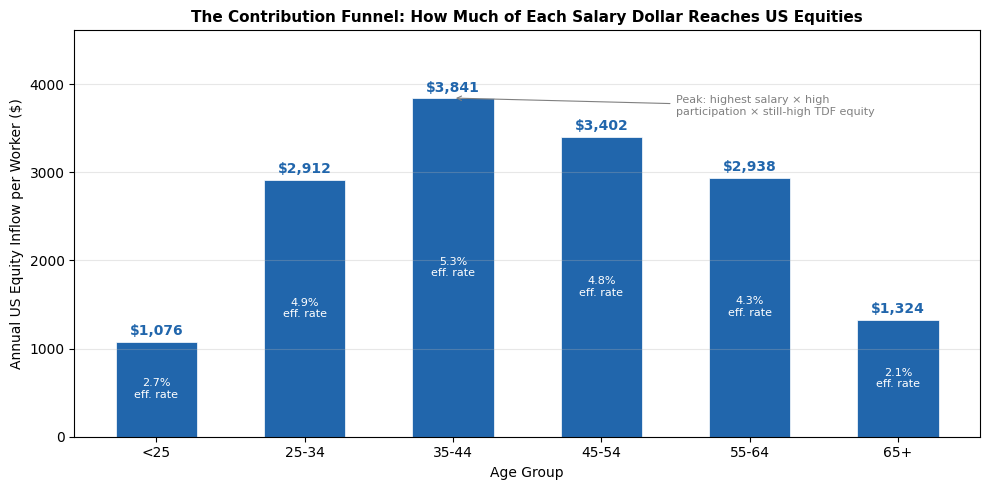


Decomposition: Salary × Participation × Contribution × TDF US Equity = $/Worker
--------------------------------------------------------------------------------
  <25   : $39,979 × 54% × 9.3% × 53.6% = $1,076
  25-34 : $59,800 × 82% × 11.1% × 53.5% = $2,912
  35-44 : $72,020 × 86% × 11.7% × 53.0% = $3,841
  45-54 : $71,604 × 87% × 12.3% × 44.4% = $3,402
  55-64 : $68,744 × 87% × 13.8% × 35.6% = $2,938
  65+   : $62,036 × 79% × 14.6% × 18.5% = $1,324


In [18]:
# ── 2.2 Contribution funnel: what share of each salary dollar reaches US equities? ───

fig, ax = plt.subplots(figsize=(10, 5))

x = np.arange(len(age_groups))
width = 0.55

# The punchline: effective annual $ per worker reaching US equities
bars = ax.bar(x, params['Annual US Equity per Worker ($)'],
              width, color='#2166ac', edgecolor='white', linewidth=0.5)

# Add value labels on bars
for bar, rate in zip(bars, params['Effective US Equity Rate']):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height + 40,
            f'${height:,.0f}', ha='center', va='bottom',
            fontsize=10, fontweight='bold', color='#2166ac')
    ax.text(bar.get_x() + bar.get_width()/2, height/2,
            f'{rate:.1%}\neff. rate', ha='center', va='center',
            fontsize=8, color='white')

ax.set_xticks(x)
ax.set_xticklabels(age_groups)
ax.set_xlabel('Age Group')
ax.set_ylabel('Annual US Equity Inflow per Worker ($)')
ax.set_title('The Contribution Funnel: How Much of Each Salary Dollar Reaches US Equities',
             fontsize=11, fontweight='bold')
ax.set_ylim(0, max(params['Annual US Equity per Worker ($)']) * 1.2)
ax.grid(True, alpha=0.3, axis='y')

# Annotation: why does it peak at 35-44?
peak_idx = params['Annual US Equity per Worker ($)'].idxmax()
ax.annotate('Peak: highest salary × high\nparticipation × still-high TDF equity',
            xy=(peak_idx, params.loc[peak_idx, 'Annual US Equity per Worker ($)']),
            xytext=(peak_idx + 1.5, params.loc[peak_idx, 'Annual US Equity per Worker ($)'] * 0.95),
            fontsize=8, color='gray',
            arrowprops=dict(arrowstyle='->', color='gray', lw=0.8))

plt.tight_layout()
plt.show()

# Hard numbers alongside the chart
print("\nDecomposition: Salary × Participation × Contribution × TDF US Equity = $/Worker")
print("-" * 80)
for _, r in params.iterrows():
    sal = r['Median Annual Salary ($)']
    par = r['Participation Rate']
    con = r['Total Contribution Rate']
    tdf_eq = r['TDF US Equity Share (Model)']
    ann = r['Annual US Equity per Worker ($)']
    print(f"  {r['Age Group']:<6}: ${sal:>6,.0f} × {par:.0%} × {con:.1%} × {tdf_eq:.1%} = ${ann:>5,.0f}")

Sanity check — 2025 mid scenario:
  Total population (0-100):    338.0M
  Ages 0-15 (children):         62.2M
  Ages 16-100 (potential):     275.8M

── Employment-to-Population Ratio (BLS workers / Census population) ──
  <25     :   11,298,000 workers /   40,008,623 pop = 28.2%
  25-34   :   29,964,000 workers /   45,888,807 pop = 65.3%
  35-44   :   29,948,000 workers /   45,099,448 pop = 66.4%
  45-54   :   25,501,000 workers /   40,345,491 pop = 63.2%
  55-64   :   20,000,000 workers /   41,143,469 pop = 48.6%
  65+     :    5,861,000 workers /   63,326,603 pop = 9.3%

Plan access rate (BLS NCS): 72%


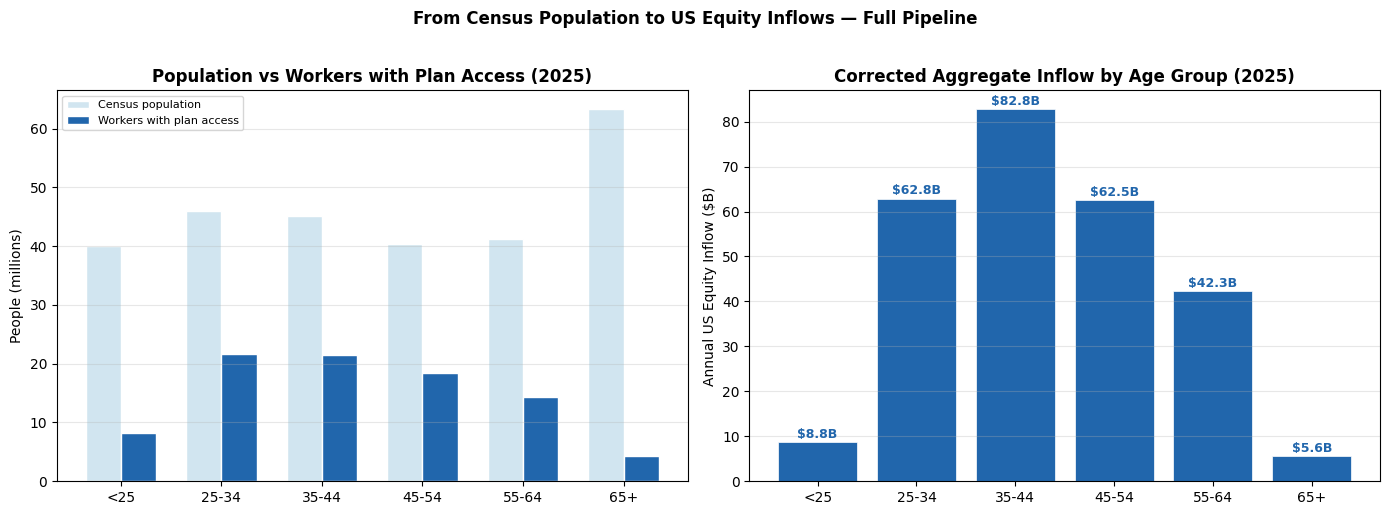


Corrected Aggregate US Equity Inflows — 2025 (mid scenario)
Age        Population  Empl Ratio  ×Plan Acc  ×Partic   $/Worker  Inflow($B)   Share
-------------------------------------------------------------------------------------
<25        40,008,623      28.2%       72%     54% $    1,076 $       8.8    3.3%
25-34      45,888,807      65.3%       72%     82% $    2,912 $      62.8   23.7%
35-44      45,099,448      66.4%       72%     86% $    3,841 $      82.8   31.3%
45-54      40,345,491      63.2%       72%     87% $    3,402 $      62.5   23.6%
55-64      41,143,469      48.6%       72%     87% $    2,938 $      42.3   16.0%
65+        63,326,603       9.3%       72%     79% $    1,324 $       5.6    2.1%
-------------------------------------------------------------------------------------
TOTAL     275,812,441                                            $     264.8  100.0%

── Sanity check: implied active participants ──
  Our estimate:  72.5M
  ICI FactBook:  70M
  Ratio:    

In [ ]:
# ── 2.3 Where do aggregate inflow dollars come from? ────────────────────────
# Combine per-worker inflow (Cell 2.1) with Census population (Module 1)
# CRITICAL: must account for employment rate and plan access, not just
# apply Vanguard's participation rate to the entire Census population.

# ── Step 1: Sanity check population ──
total_pop_2025 = pop_mid.loc[2025].sum()
pop_16plus = pop_mid.loc[2025, 16:100].sum()
print(f"Sanity check — 2025 mid scenario:")
print(f"  Total population (0-100):  {total_pop_2025/1e6:>7.1f}M")
print(f"  Ages 0-15 (children):      {(total_pop_2025 - pop_16plus)/1e6:>7.1f}M")
print(f"  Ages 16-100 (potential):   {pop_16plus/1e6:>7.1f}M")

# ── Step 2: Map Census ages to our age groups ──
age_bins = {
    '<25':   (16, 24),
    '25-34': (25, 34),
    '35-44': (35, 44),
    '45-54': (45, 54),
    '55-64': (55, 64),
    '65+':   (65, 100),
}

pop_by_group = {}
for group, (lo, hi) in age_bins.items():
    pop_by_group[group] = pop_mid.loc[2025, lo:hi].sum()

params['Population 2025'] = [pop_by_group[a] for a in age_groups]

# ── Step 3: Employment-to-population ratio (derived from BLS / Census) ──
# BLS gives full-time wage & salary workers (thousands) by age group
bls_workers = {
    '<25':   workers_under25,      # from our earlier merge (thousands)
    '25-34': bls.loc[bls['Age Group'] == '25-34', 'Workers (000s)'].values[0],
    '35-44': bls.loc[bls['Age Group'] == '35-44', 'Workers (000s)'].values[0],
    '45-54': bls.loc[bls['Age Group'] == '45-54', 'Workers (000s)'].values[0],
    '55-64': bls.loc[bls['Age Group'] == '55-64', 'Workers (000s)'].values[0],
    '65+':   bls.loc[bls['Age Group'] == '65+',   'Workers (000s)'].values[0],
}

params['BLS Workers (000s)'] = [bls_workers[a] for a in age_groups]
params['Employment Ratio'] = (
    params['BLS Workers (000s)'] * 1000 / params['Population 2025']
)

print(f"\n── Employment-to-Population Ratio (BLS workers / Census population) ──")
for _, r in params.iterrows():
    print(f"  {r['Age Group']:<8}: {r['BLS Workers (000s)']*1000:>12,.0f} workers / "
          f"{r['Population 2025']:>12,.0f} pop = {r['Employment Ratio']:.1%}")

# ── Step 4: Plan access rate ──
# BLS National Compensation Survey: ~72% of all workers have access to
# employer retirement plans. Varies by sector but we use aggregate.
# Source: BLS Employee Benefits Survey 2024
PLAN_ACCESS_RATE = 0.72
print(f"\nPlan access rate (BLS NCS): {PLAN_ACCESS_RATE:.0%}")

# ── Step 5: Corrected aggregate inflow ──
# Full pipeline: Pop × Employment × Plan Access × Participation × Salary × Contrib × TDF Equity
params['Aggregate Inflow ($B)'] = (
    params['Population 2025']
    * params['Employment Ratio']
    * PLAN_ACCESS_RATE
    * params['Participation Rate']
    * params['Median Annual Salary ($)']
    * params['Total Contribution Rate']
    * params['TDF US Equity Share (Model)']
    / 1e9
)

# ── Chart ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left panel: population vs employed with plan access
ax = axes[0]
x = np.arange(len(age_groups))
w = 0.35
ax.bar(x - w/2, params['Population 2025'] / 1e6,
       w, color='#d1e5f0', edgecolor='white', label='Census population')
ax.bar(x + w/2,
       params['BLS Workers (000s)'] * 1000 * PLAN_ACCESS_RATE / 1e6,
       w, color='#2166ac', edgecolor='white', label='Workers with plan access')
ax.set_xticks(x)
ax.set_xticklabels(age_groups)
ax.set_ylabel('People (millions)')
ax.set_title('Population vs Workers with Plan Access (2025)', fontweight='bold')
ax.legend(fontsize=8)
ax.grid(True, alpha=0.3, axis='y')

# Right panel: corrected aggregate inflow
ax = axes[1]
bars = ax.bar(age_groups, params['Aggregate Inflow ($B)'],
              color='#2166ac', edgecolor='white', linewidth=0.5)
for bar in bars:
    h = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, h + 0.3,
            f'${h:.1f}B', ha='center', va='bottom', fontsize=9,
            fontweight='bold', color='#2166ac')
ax.set_ylabel('Annual US Equity Inflow ($B)')
ax.set_title('Corrected Aggregate Inflow by Age Group (2025)', fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('From Census Population to US Equity Inflows — Full Pipeline',
             fontsize=12, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ── Hard numbers ──
total = params['Aggregate Inflow ($B)'].sum()
print(f"\nCorrected Aggregate US Equity Inflows — 2025 (mid scenario)")
print("=" * 85)
print(f"{'Age':<8} {'Population':>12} {'Empl Ratio':>11} {'×Plan Acc':>10} "
      f"{'×Partic':>8} {'$/Worker':>10} {'Inflow($B)':>11} {'Share':>7}")
print("-" * 85)
for _, r in params.iterrows():
    pop = r['Population 2025']
    emp = r['Employment Ratio']
    par = r['Participation Rate']
    ann = r['Annual US Equity per Worker ($)']
    agg = r['Aggregate Inflow ($B)']
    share = agg / total * 100
    print(f"{r['Age Group']:<8} {pop:>12,.0f} {emp:>10.1%} {PLAN_ACCESS_RATE:>9.0%} "
          f"{par:>7.0%} ${ann:>9,.0f} ${agg:>10.1f} {share:>6.1f}%")
print("-" * 85)
print(f"{'TOTAL':<8} {params['Population 2025'].sum():>12,.0f} {'':>11} {'':>10} "
      f"{'':>8} {'':>10} ${total:>10.1f} {'100.0%':>7}")

# ── Cross-check against known aggregate ──
known_participants = 70  # ~70M active 401(k) participants (ICI FactBook 2025)
our_participants = (
    params['Population 2025'] * params['Employment Ratio'] * PLAN_ACCESS_RATE
    * params['Participation Rate']
).sum() / 1e6
print(f"\n── Sanity check: implied active participants ──")
print(f"  Our estimate:  {our_participants:.1f}M")
print(f"  ICI FactBook:  {known_participants}M")
print(f"  Ratio:         {our_participants/known_participants:.2f}x")
print(f"  {'Reasonable' if 0.7 < our_participants/known_participants < 1.3 else 'CHECK THIS'}")

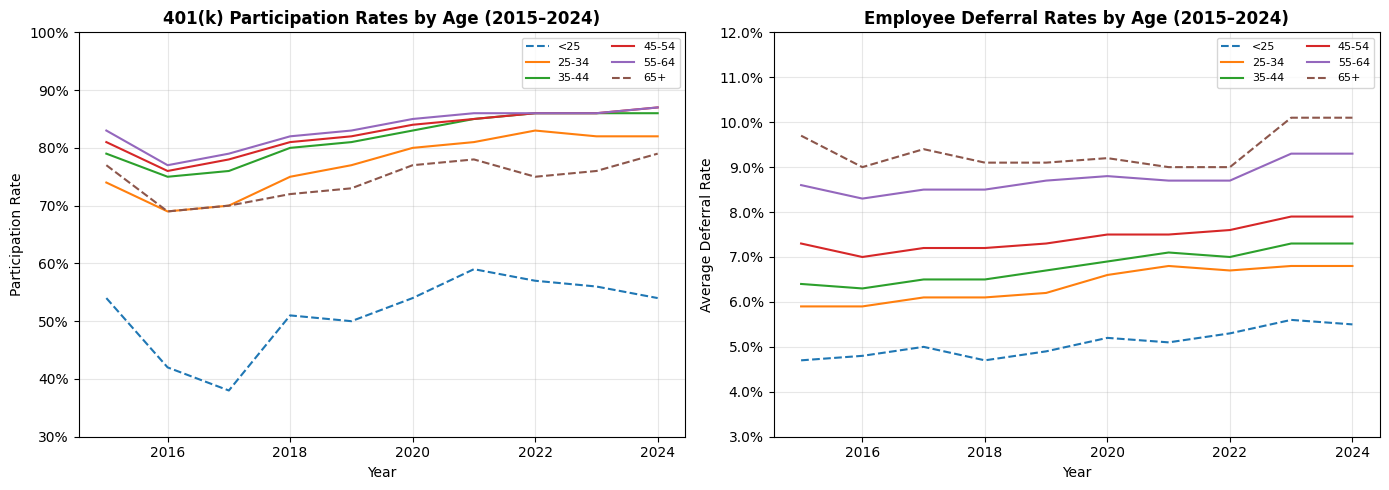

Parameter stability check: 2015 vs 2024
Age Group   Partic 2015  Partic 2024        Δ  Deferral 2015  Deferral 2024        Δ
-----------------------------------------------------------------
<25              54.0%       54.0%   +0.0%          4.7%          5.5%   +0.8%
25-34            74.0%       82.0%   +8.0%          5.9%          6.8%   +0.9%
35-44            79.0%       86.0%   +7.0%          6.4%          7.3%   +0.9%
45-54            81.0%       87.0%   +6.0%          7.3%          7.9%   +0.6%
55-64            83.0%       87.0%   +4.0%          8.6%          9.3%   +0.7%
65+              77.0%       79.0%   +2.0%          9.7%         10.1%   +0.4%
-----------------------------------------------------------------

Conclusion: Participation rose ~5-10pp (2015-2020) then plateaued.
Deferral rates drifted up ~1-2pp over decade. Both sufficiently
stable to treat as constants in the base case model, with a mild
upward trend as sensitivity scenario.


In [20]:
# ── 2.4 Parameter stability: can we treat rates as constants in the model? ──
# Load time series from Vanguard extraction

partic_trend = pd.read_excel(
    f'{DATA_PATH}/module2_inflows/vanguard_data_extraction.xlsx',
    sheet_name='Participation_Trend', header=2
)
deferral_trend = pd.read_excel(
    f'{DATA_PATH}/module2_inflows/vanguard_data_extraction.xlsx',
    sheet_name='Deferral_Trend', header=2
)

# Clean: drop source note rows
partic_trend = partic_trend.dropna(subset=[partic_trend.columns[1]])
deferral_trend = deferral_trend.dropna(subset=[deferral_trend.columns[1]])

years = [str(y) for y in range(2015, 2025)]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Participation rates over time
ax = axes[0]
for _, row in partic_trend.iterrows():
    group = row['Age Group']
    if group == 'All':
        continue
    vals = [row[y] for y in years]
    style = '-' if group in ['25-34', '35-44', '45-54', '55-64'] else '--'
    ax.plot(range(2015, 2025), vals, label=group, linewidth=1.5, linestyle=style)

ax.set_xlabel('Year')
ax.set_ylabel('Participation Rate')
ax.set_title('401(k) Participation Rates by Age (2015–2024)', fontweight='bold')
ax.legend(fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.3, 1.0)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))

# Right: Deferral rates over time
ax = axes[1]
for _, row in deferral_trend.iterrows():
    group = row['Age Group']
    if group == 'All':
        continue
    vals = [row[y] for y in years]
    style = '-' if group in ['25-34', '35-44', '45-54', '55-64'] else '--'
    ax.plot(range(2015, 2025), vals, label=group, linewidth=1.5, linestyle=style)

ax.set_xlabel('Year')
ax.set_ylabel('Average Deferral Rate')
ax.set_title('Employee Deferral Rates by Age (2015–2024)', fontweight='bold')
ax.legend(fontsize=8, ncol=2)
ax.grid(True, alpha=0.3)
ax.set_ylim(0.03, 0.12)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.1%}'))

plt.tight_layout()
plt.show()

# Hard numbers: 2015 vs 2024 change
print("Parameter stability check: 2015 vs 2024")
print("=" * 65)
print(f"{'Age Group':<10} {'Partic 2015':>12} {'Partic 2024':>12} {'Δ':>8} {'Deferral 2015':>14} {'Deferral 2024':>14} {'Δ':>8}")
print("-" * 65)
for i in range(len(partic_trend)):
    p = partic_trend.iloc[i]
    d = deferral_trend.iloc[i]
    group = p['Age Group']
    if group == 'All':
        continue
    p15 = p['2015']
    p24 = p['2024']
    d15 = d['2015']
    d24 = d['2024']
    print(f"{group:<10} {p15:>11.1%} {p24:>11.1%} {p24-p15:>+7.1%} {d15:>13.1%} {d24:>13.1%} {d24-d15:>+7.1%}")
print("-" * 65)
print("\nConclusion: Participation rose ~5-10pp (2015-2020) then plateaued.")
print("Deferral rates drifted up ~1-2pp over decade. Both sufficiently")
print("stable to treat as constants in the base case model, with a mild")
print("upward trend as sensitivity scenario.")

In [22]:
# ── 2.5 Save processed parameters for Module 2 model ───────────────────────
# Export clean parameter table so 02_model.ipynb loads one CSV, not three Excel files.

output_path = f'{DATA_PATH}/processed'

# Core parameters the model needs (one row per age group)
model_params = params[[
    'Age Group', 'Median Annual Salary ($)', 'Participation Rate',
    'Total Contribution Rate', 'TDF US Equity Share (Model)',
    'Avg Equity Allocation (Actual)', 'Employment Ratio',
    'Effective US Equity Rate', 'Annual US Equity per Worker ($)',
    'Population 2025', 'BLS Workers (000s)'
]].copy()

model_params.to_csv(f'{output_path}/module2_inflow_params.csv', index=False)

# Also save the plan access rate as a standalone reference
with open(f'{output_path}/module2_constants.txt', 'w') as f:
    f.write(f"PLAN_ACCESS_RATE=0.72\n")
    f.write(f"SOURCE=BLS National Compensation Survey 2024\n")
    f.write(f"NOTE=72% of all workers have access to employer retirement plans\n")

print(f"Saved to {output_path}/:")
print(f"  module2_inflow_params.csv  ({model_params.shape[0]} rows × {model_params.shape[1]} cols)")
print(f"  module2_constants.txt")
print(f"\nPreview:")
print(model_params.to_string(index=False))

Saved to ..\data/processed/:
  module2_inflow_params.csv  (6 rows × 11 cols)
  module2_constants.txt

Preview:
Age Group  Median Annual Salary ($)  Participation Rate  Total Contribution Rate  TDF US Equity Share (Model)  Avg Equity Allocation (Actual)  Employment Ratio  Effective US Equity Rate  Annual US Equity per Worker ($)  Population 2025  BLS Workers (000s)
      <25                 39,979.30                0.54                     0.09                         0.54                            0.87              0.28                      0.03                         1,076.16         40008623           11,298.00
    25-34                 59,800.00                0.82                     0.11                         0.54                            0.88              0.65                      0.05                         2,912.00         45888807           29,964.00
    35-44                 72,020.00                0.86                     0.12                         0.53            

# Module 3: Outflows — Data Exploration

**Goal:** Understand the mechanics and magnitude of retirement account outflows — RMDs, voluntary withdrawals, and TDF de-risking — to calibrate parameters for the model notebook.

**Key question:** How much money leaves passive equity funds each year through mandatory and voluntary withdrawals, and how does the TDF glide path dampen the equity impact?

**Data sources:**
- IRS Publication 590-B, Table III (Uniform Lifetime) — RMD divisors by age
- Federal Reserve Survey of Consumer Finances (SCF) — retirement account balances and ownership by age, 1989–2022
- Vanguard "How America Retires" 2025 — withdrawal behavior patterns
- TDF glide path allocations (from Module 2)

**Formula:**
$$\text{Annual Equity Outflow}_{age, year} = \text{Population} \times \text{Ownership Rate} \times \text{Balance} \times \max(\text{RMD Rate}, \text{Voluntary Rate}) \times \text{TDF US Equity Share}$$

FileNotFoundError: [Errno 2] No such file or directory: 'data\\module3_outflows\\irs_table_iii_uniform_lifetime.csv'